In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### Load the relevant data

In [2]:
# SDSS + GZ2
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')
sdss_morph = Table.read('fits/morph_data.fits')
sdss_structure = Table.read('fits/structure_data.fits')
sdss_hi = Table.read('fits/hi_data.fits')

In [3]:
# S4G
s4g_galaxy = Table.read('s4g_fits/galaxy_data.fits')
s4g_structure = Table.read('s4g_fits/bulge_disc_matched.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')
s4g_psi = Table.read('s4g_fits/psi_matched.fits')

#### Sample selection

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


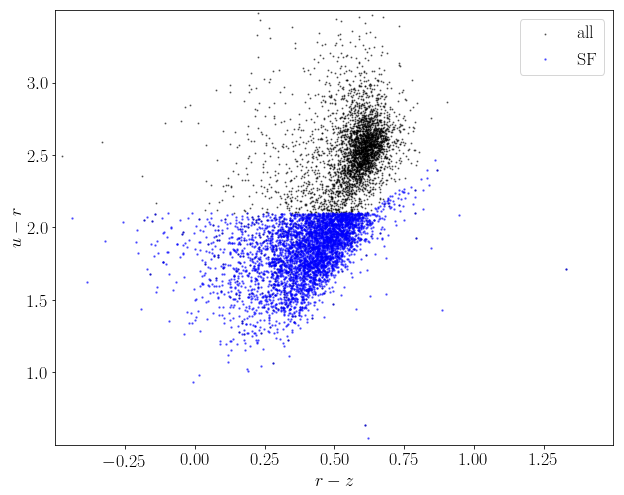

In [4]:
masks = Table.read('fits/masks.fits')

# --- Select star-forming ---
u_r = gz2_data['PETROMAG_MU'] - gz2_data['PETROMAG_MR']
r_z = gz2_data['PETROMAG_MR'] - gz2_data['PETROMAG_MZ']
star_forming = np.any([u_r < 2.1,u_r < 1.6*r_z + 1.1],axis=0)

_ = plt.scatter(r_z[:4000],u_r[:4000],color='k',s=1,alpha=0.5,label='all')
_ = plt.scatter(r_z[star_forming][:4000],u_r[star_forming][:4000],
                color='b',s=2,alpha=0.5,label='SF')
_ = plt.axis((-0.5,1.5,0.5,3.5))
_ = plt.xlabel('$r-z$')
_ = plt.ylabel('$u-r$')
_ = plt.legend()
masks['star_forming'] = star_forming

masks.write('fits/masks.fits',overwrite=True)

In [5]:
# Morphological selection of unbarred S4G galaxies (Buta+)
has_arms = np.any([s4g_morph['AC'] == b'G',s4g_morph['AC'] == b'M',
                   s4g_morph['AC'] == b'F'],axis=0)

morph_ok = np.all([s4g_morph['__T_'] >= 1,
                   s4g_morph['__T_'] <= 9],axis=0)

has_arms = np.any([s4g_morph['AC'] == b'G',s4g_morph['AC'] == b'M',
                   s4g_morph['AC'] == b'F'],axis=0)
unbarred = s4g_morph['__F_'] <= 0.25

# Type decompositions: only select galaxies with a clear disc
acceptable_types = ('bd','bdbar','bdbarf','dbar','dbarf',
                    'dn','bdbarfn','dbarfn','dbarn','dbarnf')
type_ok = np.any([s4g_structure['model'] == type_ 
                  for type_ in acceptable_types],axis=0)

bulge_disc_ok = (s4g_structure['f_bulge'] 
               + s4g_structure['f_disc']) >= 0.9
# ^ only selecting the disc galaxies
fit_ok = s4g_structure['quality'] == '5' # good fits only
disc_ok = s4g_structure['R_d'] > 0

# General catalogue properties
has_mass = np.isfinite(s4g_galaxy['m_tot'])

has_psi = s4g_psi['P_abs'] > 0

s4g_sample = np.all([morph_ok,has_arms,
                     type_ok,bulge_disc_ok,fit_ok,
                     has_mass,disc_ok],axis=0)
s4g_unbarred = np.all([s4g_sample,unbarred],axis=0)
print('{}/{} galaxies with bulge+disc'.format(s4g_sample.sum(),
                                              len(s4g_sample)))
print('+ {} are unbarred'.format(s4g_unbarred.sum()))

204/2352 galaxies with bulge+disc
+ 101 are unbarred


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal


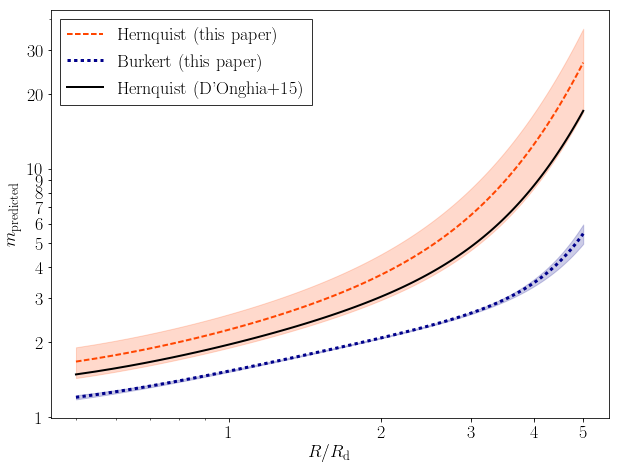

In [6]:
from halo import TotalHalo, get_halo_table

fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.3e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = None
delta_m_hi_mw = None

m_halo_mw = [9.5e11] * u.Msun
delta_m_halo_mw = [0.2] * m_halo_mw

R_halo_mw = [29.6] * u.kpc
delta_R_halo_mw = [0.2] * R_halo_mw


mw_halo = TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,a_b_mw,
                    delta_a_b_mw,R_d_mw,delta_R_d_mw,m_hi_mw,delta_m_hi_mw,
                    None,None,None,None,1,0)

d15_halo = TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,a_b_mw,
                     delta_a_b_mw,R_d_mw,delta_R_d_mw,m_hi_mw,delta_m_hi_mw,
                     m_halo_mw,delta_m_halo_mw,R_halo_mw,delta_R_halo_mw,1,0)

ys = np.linspace(0.25,2.5,100)
m_d15 = d15_halo.m_predicted(ys,halo='hernquist')
m_hernquist = mw_halo.m_predicted(ys,halo='hernquist')
m_burkert = mw_halo.m_predicted(ys,halo='burkert')
ms = [m_hernquist,m_burkert,m_d15]
                 
labels = ('Hernquist (this paper)','Burkert (this paper)',
          "Hernquist (D'Onghia+15)")

colors = ('orangered','darkblue','k')
linestyles = ('dashed','dotted','solid')
linewidths = (2,3,2)
errorbars = (True, True, False)


for (m,c,s,w,l,e) in zip(ms,colors,linestyles,linewidths,labels,errorbars):
    _ = ax.plot(m['R']/R_d_mw,m['m'],
                color=c,lw=w,linestyle=s,label=l)
    if e is True:
        _ = ax.fill_between((m['R']/R_d_mw).data,(m['m']+m['error']).data,
                            (m['m']-m['error']).data,
                            color=c,alpha=0.2,label='_nolegend_')
        

_ = ax.legend(edgecolor='k',fancybox=False,loc='upper left')
_ = ax.set_xlabel('$R/R_\mathrm{d}$')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

_ = ax.set_xticks([1,2,3,4,5])
_ = ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
_ = ax.set_yticks([1,2,3,4,5,6,7,8,9,10,20,30])
_ = ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

#fig.savefig('figures/milky_way.pdf')

In [7]:
# S4G galaxies ...

m_tot = s4g_galaxy['m_tot'][s4g_sample] * u.Msun
delta_m_tot = s4g_galaxy['delta_m_tot'][s4g_sample] * u.Msun

m_b = s4g_structure['f_bulge'][s4g_sample].data * m_tot
m_b[m_b < 0] = 0
delta_m_b = s4g_structure['f_bulge'][s4g_sample].data * delta_m_tot
delta_m_b[delta_m_b < 0] = 0

m_d = s4g_structure['f_disc'][s4g_sample].data * m_tot
m_d[m_d < 0] = 0
delta_m_d = s4g_structure['f_disc'][s4g_sample].data * delta_m_tot
delta_m_d[delta_m_d < 0] = 0

a_b = s4g_structure['R_b'][s4g_sample].data * u.kpc
a_b[a_b < 0] = 0
delta_a_b = s4g_structure['delta_R_b'][s4g_sample].data * u.kpc
delta_a_b[a_b < 0] = 0

R_d = s4g_structure['R_d'][s4g_sample].data * u.kpc
R_d[R_d < 0] = 0
delta_R_d = s4g_structure['delta_R_d'][s4g_sample].data * u.kpc
R_d[delta_R_d < 0] = 0

s4g_halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                      R_d, delta_R_d, None, None)

In [8]:
# Sloan galaxies ...

sample_ok = masks['z<0.085 (+HI)'].copy()
# only do 200 to save time for now...
#sample_adjust = np.argwhere(sample_ok == True)[200:]
#sample_ok[sample_adjust] = False

m_b = sdss_structure['m_b'][sample_ok].data * u.Msun
delta_m_b = sdss_structure['delta_m_b'][sample_ok].data * u.Msun
# Remove gals. with small poorly fit bulges
no_bulge = sdss_structure[sample_ok]['Type'] == 2
m_b[no_bulge] = 0 * u.Msun
delta_m_b[no_bulge] = 0* u.Msun

m_d = sdss_structure['m_d'][sample_ok].data * u.Msun
delta_m_d = sdss_structure['delta_m_d'][sample_ok].data * u.Msun

a_b = sdss_structure['R_b'][sample_ok].data * u.kpc
delta_a_b = sdss_structure['delta_R_b'][sample_ok].data * u.kpc

R_d = sdss_structure['R_d'][sample_ok].data * u.kpc
delta_R_d = sdss_structure['delta_R_d'][sample_ok].data * u.kpc

m_hi = sdss_hi['hi_mass'][sample_ok].data * u.Msun
delta_m_hi = sdss_hi['hi_mass_error'][sample_ok].data * u.Msun
#fig, axarr = plt.subplots(2,4,figsize=(20,10))

sdss_halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                       R_d, delta_R_d, None, None)

sdss_w_gas = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                        R_d, delta_R_d, m_hi, delta_m_hi)

In this notebook, we now have four different haloes to compare:

* SDSS stellar
* SDSS stellar+gas discs
* S4G
* Milky Way

In [9]:
sdss_halo_table = get_halo_table(sdss_halos)
sdss_w_gas_table = get_halo_table(sdss_w_gas)
s4g_halo_table = get_halo_table(s4g_halos)

In [10]:
def match_tables(match_table,halo_table,mask,id_column):
    matched_table = Table()
    for c in halo_table.colnames:
        matched_table[c] = np.full(len(match_table),-999,dtype='float64')
        matched_table[c][mask] = halo_table[c]
    
    matched_table['id'] = match_table[id_column]
    matched_table['mask'] = mask
    return matched_table

sdss_halo_table_matched = match_tables(gz2_data,sdss_halo_table,
                                       sample_ok,'dr7objid')
sdss_w_gas_table_matched = match_tables(gz2_data,sdss_w_gas_table,
                                        sample_ok,'dr7objid')
s4g_halo_table_matched = match_tables(s4g_galaxy,s4g_halo_table,s4g_sample,
                                'object')
s4g_halo_table_matched['unbarred_sample'] = s4g_unbarred

In [11]:
sdss_halo_table.write('fits/sdss_halo_table.fits',overwrite=True)
sdss_w_gas_table.write('fits/sdss_w_gas_table.fits',overwrite=True)
s4g_halo_table.write('fits/s4g_halo_table.fits',overwrite=True)

sdss_halo_table_matched.write('fits/sdss_halo_table_matched.fits',
                              overwrite=True)
sdss_w_gas_table_matched.write('fits/sdss_w_gas_table_matched.fits',
                               overwrite=True)
s4g_halo_table_matched.write('fits/s4g_halo_table_matched.fits',
                             overwrite=True)